# Deep Unfolding applied to gradient descent
using: \
Julia 1.8.2 \
Flux.jl 0.13.6 \
Zygote.jl 0.6.49 \
Symbolics 5.10.0 \
\
In this Jupyter notebook, I explore applying Deep Unfolding (DU) to gradient descent algorithms. The notebook is based on Tadashi Wadayama's work found at https://github.com/wadayama/DU-Book/blob/main/Chapter_3/. 

Deep Unfolding treats iterative algorithms as if each iteration were a layer in a deep neural network. In this notebook, I consider applying DU to gradient descent, which iteratively modifies an input vector $x_k$ to minimize an objective function $f(x)$ using the recursive formula:

$$
x_{k+1} = x_k -\eta\cdot\nabla f(x_k),
$$

where $\nabla f(x)$ is the gradient of $f(x)$, and $\eta$ is the step size parameter. Here, $\eta$ is a parameter to be learned. 

I calculate $\nabla f(x)$ symbolically and use it in the recursive equation, converting it to a numerically evaluated function. Meanwhile, I calculate the gradient of the DU parameters (here just the scalar $\eta$) via automatic differentiation and optimize it using the Adam algorithm.

## A simple constant-parameter-learning example

In [24]:
using LinearAlgebra
using Plots
gr()
using Random
Random.seed!(1)
using Flux
using Symbolics

Define an objective function to minimize. We use Symbolics package to compute the gradient of the function.

In [25]:
@variables x[1:2]

#f(x)=(1-x[1])^2+100*(x[2]-x[1]^2)^2 # Rosenbrock function
f(x) = x[1]^2+x[2]^2 # Quadratic function

g(x)=Symbolics.gradient(f(x),Symbolics.get_variables(f(x))) # compute symbolically the gradient of f(x)

g_expr = build_function(g(x),x) 
callable_gradient=eval(g_expr[1]) # we obtain a function that returns a numerical gradient
callable_gradient([1,1]) # sanity check

2-element Vector{Int64}:
 2
 2

Define a function that performs gradient descent. We will learn the step size $\eta$ or eta[1] (a scalar) using Deep Unfolding.

In [26]:
function GD_ki(max_itr, x0, eta)
    x = x0
    for i in 1:max_itr
        #df = gradient(() -> f(x), Flux.params(x)) 
        # The above line cannot be done because Flux.gradient cannot take gradient of itself.
        # We can hard-code df = 2*x or we can symbolically get the gradient and convert into a function 
        # returning numerical vector.
        
        x = x - eta[1].*callable_gradient(x)
    end
    return f(x)
end

GD_ki (generic function with 2 methods)

Define the train function that does the "deep unfolding". Here we perform automatic differentiation of the gradient descent algorithm using Flux.gradient. 

In [27]:
function train_ki(opt, eta, max_itr, train_itr)
    ps = Flux.params(eta) 
    l = [] # will keep record of eta values in this list
    for i in 1:train_itr # perform gradient descent starting from train_iter random starting points
        push!(l,eta[1]) # like append in python
        gs = Flux.gradient(ps) do
            GD_ki(max_itr, randn(2), eta) # perform gradient descent for max_itr iterations 
        end
        Flux.Optimise.update!(opt, ps, gs)   
    end  
    return l
end

train_ki (generic function with 1 method)

We plot the history of $\eta$ with respect to training iteration. The optimization algorithm employed is ADAM. It converges to the optimal value of $\eta = 0.5$ for the quadratic function.

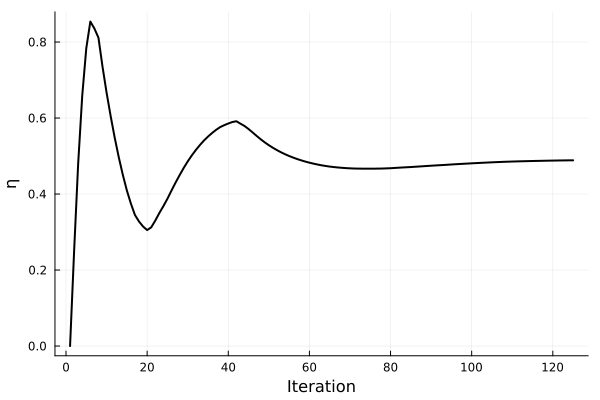

In [28]:
opt = Flux.ADAM(0.25) 
eta = [0.0]
max_itr = 2
train_itr = 125
l = train_ki(opt, eta, max_itr, train_itr)
plot(1:train_itr,l, xlabel="Iteration", ylabel="η",legend=false, lw=2,color=:black)

## A Second Quadratic Function Descent Example

In [29]:
n = 100 #number of dimension of the quadratic function
num_itr = 30
train_itr = 25
K = 50 #batch size
adam_lr = 1e-3 #learning rate for ADAM algorithm to learn eta
max_inner = 20

20

In [30]:
A = diagm(1:n)
#println(A)
λmin = 1
λmax = n
ηopt = 1/(λmin + λmax)

0.009900990099009901

In [31]:
@variables x[1:n]
x=Symbolics.scalarize(x)
f(x)= x'*A*x

g(x)=Symbolics.gradient(f(x),[x[i] for i in 1:n]) # compute symbolically the gradient of f(x)

g_expr = build_function(g(x),x) 
callable_gradient=eval(g_expr[1]) # we obtain a function that returns a numerical gradient



#41 (generic function with 1 method)

As a benchmark we compute fixed-step-size gradient descent.

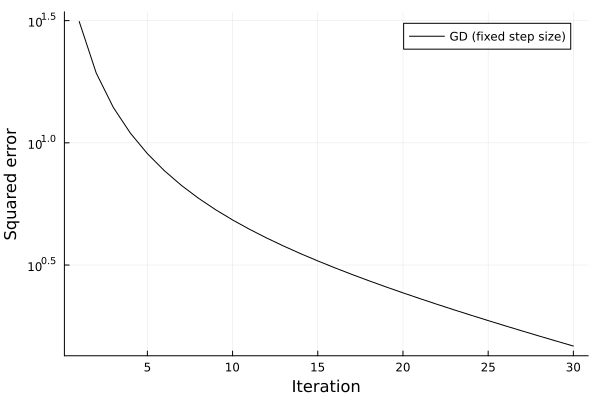

In [32]:
function GD_ki(max_itr, x0)
    x = x0
    for i in 1:max_itr
        #x = x - ηopt*2*A*x
        x = x - ηopt*callable_gradient(x)
    end
    return x
end

function comp_se(max_itr,x0)
    x̂ = GD_ki(max_itr, x0)
    return norm(x̂)^2
end

xinit = randn(n)
GD_mse = [comp_se(i,xinit) for i in 1:num_itr]
plot(1:num_itr, GD_mse, lw=1, yscale=:log10, label="GD (fixed step size)", color=:black,  xlabel="Iteration", ylabel="Squared error")


The following is a deep-unfolding-gradient-descent algorithm that has cyclic vairable step-sizes $\eta$ with period T.

In [33]:
function DU_GD_ki(max_itr, x0, η, T)
    x = x0
     
    for i in 0:max_itr-1
        k = (i % T)+1
        #x = x - η[k]*A*x
        if isa(x, Matrix)
            array_x = [callable_gradient(x[:,j]) for j in 1:K]
            x = x - η[k]*hcat(array_x...)
        else isa(x, Vector)
            x = x - η[k]*callable_gradient(x)
        end
    end
    return x
end

DU_GD_ki (generic function with 1 method)

The loss function to be used in the training algorithm is a mean square error of K trials (in other words, K is the batch size).

In [34]:
function loss(x̂)
    return norm(x̂)^2/K #this is the error of the batch
end 

loss (generic function with 1 method)

The training algorithm defined below takes the automatic gradient of the deep-unfolding-gradient-descent algorithm

In [35]:
function train(opt, η, T, train_itr)
    ps = Flux.params(η) 
    for itr in 1:train_itr
        for i in 1:max_inner
            x0 = randn(n,K)
            gs = Flux.gradient(ps) do
                x_est = DU_GD_ki(itr, x0, η, T)
                loss(x_est)
            end
            Flux.Optimise.update!(opt, ps, gs)
        end
        x0 = randn(n,K)
        x_est = DU_GD_ki(itr, x0, η, T)
        println(itr, " ", loss(x_est))
    end
end

train (generic function with 1 method)

In [36]:
function comp_se_DUGD(max_itr, x0, η, T)
    x_est = DU_GD_ki(max_itr, x0, η, T)
    return loss(x_est)
end

comp_se_DUGD (generic function with 1 method)

The $\eta$ is now trained (learned) as if it were a weight in deep learning algorithms, as iterations are viewed as equivalent of layers in deep neural networks.
The $\eta$ takes cyclic values of period T, which means that it is a vector of length T.

1 28.48411592236689
2 11.112000943970159
3 5.912898463113074
4 4.705876642537471
5 2.937423497894282
6 2.4248129794560076
7 2.159702679472904
8 1.3912610565586767
9 1.6550204383985128
10 1.1274617368653914
11 0.8949270925470639
12 0.6410250255592522
13 0.6907530029756775
14 0.593028342958126
15 0.70916330426185
16 0.573484876834452
17 0.40971004578940085
18 0.3710158063721976
19 0.3760172993231112
20 0.22058906239987677
21 0.21194624483387886
22 0.23648125036814668
23 0.1913227628265721
24 0.26684201041020367
25 0.1596768830448323


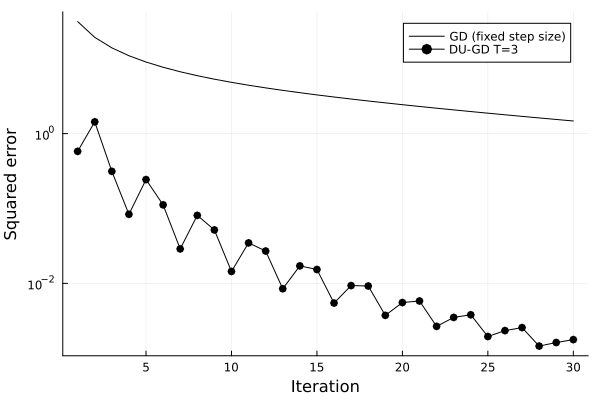

In [37]:
T = 3
η_train = zeros(num_itr) 
opt = Flux.ADAM(adam_lr) 
train(opt, η_train, T, train_itr)
DUGD_mse =[comp_se_DUGD(i, xinit, η_train, T) for i in 1:num_itr]
opt_param1 = [η_train[(i%T)+1] for i in 0:num_itr-1]
plot!(1:num_itr, DUGD_mse, lw=1, label="DU-GD T="*string(T), color=:black, marker=:o)

1 27.34867503383185
2 10.348363062468504
3 6.807341728183835
4 4.089661597953169
5 2.843394565617648
6 2.0112697578471184
7 1.6135764821707588
8 1.468730523172365
9 0.8977495304386295
10 0.8382390922412286
11 0.7948778464888637
12 0.3829666512497357
13 0.5296379053798166
14 0.5516127058331793
15 0.5394153592116867
16 0.5716273368469128
17 0.37413474581914263
18 0.3387919524831501
19 0.2602614348905049
20 0.1872488765232191
21 0.2479168545313193
22 0.1580674683072133
23 0.18349472125083197
24 0.09480722037074911
25 0.10516346780448593


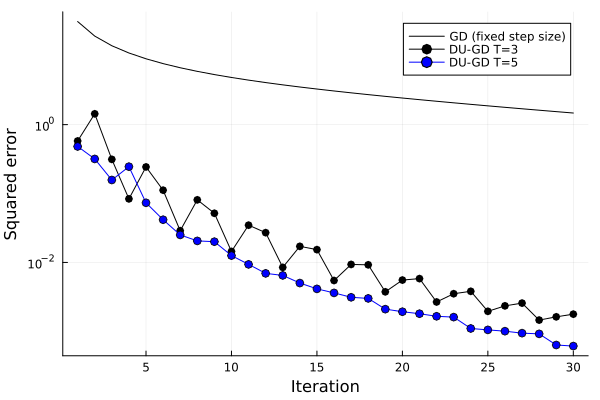

In [38]:
T = 5
η_train = zeros(num_itr) 
opt = Flux.ADAM(adam_lr) 
train(opt, η_train, T, train_itr)
DUGD_mse2 =[comp_se_DUGD(i, xinit, η_train, T) for i in 1:num_itr]
opt_param2 = [η_train[(i%T)+1] for i in 0:num_itr-1]
plot!(1:num_itr, DUGD_mse2, lw=1, label="DU-GD T="*string(T), color=:blue, marker=:o)

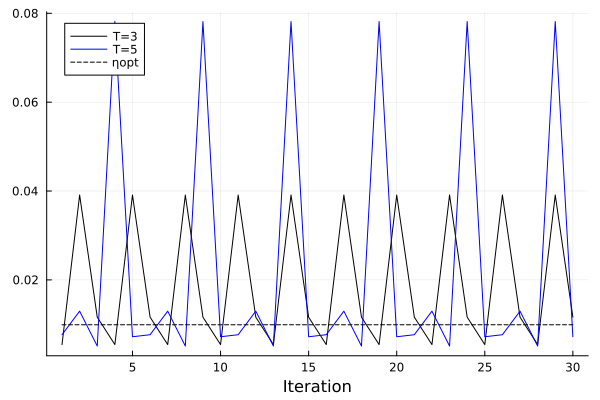

In [39]:
plot(1:num_itr, opt_param1, lw=1, label="T=3", color=:black, ls=:solid, xlabel="Iteration", ylabel="$\eta")
plot!(1:num_itr, opt_param2, lw=1, label="T=5", color=:blue, ls=:solid)
plot!(1:num_itr, x->ηopt, lw=1, label="ηopt", color=:black, ls=:dash)